# Spike and Slab GP-LVM for Factor Analysis

## Model Definition

GP-LVM (Lawrence 2005) with a linear kernel:
\begin{equation}
p(Y|X) = \prod_{d=1}^D p(y_{:,d}| X), \quad p(y_{:,d}|X) = \mathcal{N}(y_{:,d}; 0, XX^T+\beta^{-1}I)
\end{equation}
It is related to probabilistic PCA, while giving a prior distribution over the weight matrix $W$ instead of $X$ and marginalizing $W$:
\begin{equation}
p(Y|X) = \prod_{d=1}^D \mathcal{N}(y_{:,d};Xw_d, \beta^{-1}I), \quad
p(W) = \prod_{d=1}^D \mathcal{N}(w_d; 0, I).
\end{equation}

GP-LVM has been extended by giving a prior over $X$, known as Bayesian GP-LVM (Titsias & Lawrence 2010).
\begin{equation}
p(X) = \prod_{n=1}^N \mathcal{N}(x_n; 0, I)
\end{equation}

For factor analysis, it is often useful to assume $X$ to be sparse. Therefore, we extend Bayesian GP-LVM by assuming a Spike and Slab prior over $X$. Then, the GP model definition becomes:
\begin{align}
p(X)=\prod_{n=1}^N \mathcal{N}(x_n; 0, I), &\quad p(B) = \prod_{n=1}^N \prod_{q=1}^Q \pi^{b_{nq}} (1-\pi)^{1-b_{nq}},\\
p(Y|X) = \prod_{d=1}^D p(y_{:,d}| X), &\quad p(y_{:,d}|X) = \mathcal{N}(y_{:,d}; 0, K+\beta^{-1}I), 
\end{align}
where $K$ is calculated according to the corresponding linear kernel function:
\begin{equation}
k(x,b,x',b') = \sum_{q=1}^Q \sigma^2_q x_q b_q x'_q b'_q
\end{equation}

## An Experiment with Synthetic Data

We generate some artifical data and mixing them with a weight matrix.

In [1]:
import numpy as np
import GPy
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
from pylab import *
np.random.seed(113321)

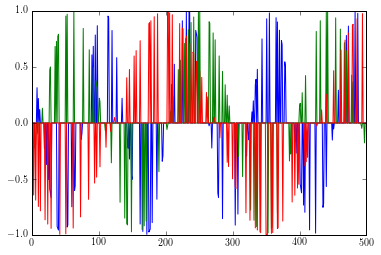

In [2]:
# Prepare the data
N,D,Q = 500, 100, 3
pi = 0.2
# sample from 3 random sine waves
X = np.sin(2*np.pi*(np.random.rand(Q)[None,:]+.5)*(np.linspace(0.,3.,N)[:,None]-np.random.rand(Q)[None,:]))
# set 80% of the values to zeros
X = X*((np.random.rand(N,Q)<pi)*1)
# plot the samples
_ = plot(X)

The obersved data $Y$ is generated by projecting the samples of the 3 sine waves onto a 100D space with a randomly generated weight matrix $W$. The first two dimensions of $Y$ is shown in the figure.

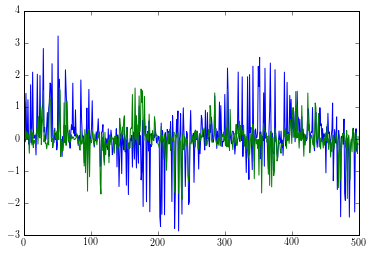

In [3]:
noise_sigma = 0.1
# Generate a weight matrix
W = np.random.randn(D,Q)
# Project to the observed space plus some Gaussian noise
y = np.dot(X,W.T)+np.random.randn(N,D)*noise_sigma
y = (y-y.mean())/y.std()
# Plot the 
_ = plot(y[:,:2])

## Applying Spike and Slab GP-LVM

We create a Spike and Slab GPLVM model object with a linear kernel:

In [4]:
m = GPy.models.SSGPLVM(y, Q, kernel=GPy.kern.Linear(Q,ARD=True),num_inducing=Q)
# Show the model parameters
m.likelihood.variance = .01
m.X.variance = .1
print m


Name : Spike_and_Slab GPLVM
Objective : 1336353.57033
Number of Parameters : 4516
Number of Optimization Parameters : 4513
Updates : True
Parameters:
  Spike_and_Slab_GPLVM.     |     value  |     constraints      |  priors
  latent space.mean         |  (500, 3)  |                      |        
  latent space.variance     |  (500, 3)  |         +ve          |        
  latent space.binary_prob  |  (500, 3)  |  1e-10,0.9999999999  |        
  inducing inputs           |    (3, 3)  |                      |        
  linear.variances          |      (3,)  |         +ve          |        
  Gaussian_noise.variance   |      0.01  |         +ve          |        
  SpikeAndSlabPrior.Pi      |      (3,)  |        fixed         |        


In [5]:
# Optimize the model parameters
m.optimize('bfgs',messages=1,max_iters=10000)

In [6]:
# Show the model parameters after optimization
print m
print m.variational_prior.pi


Name : Spike_and_Slab GPLVM
Objective : -6593.56992735
Number of Parameters : 4516
Number of Optimization Parameters : 4513
Updates : True
Parameters:
  Spike_and_Slab_GPLVM.     |            value  |     constraints      |  priors
  latent space.mean         |         (500, 3)  |                      |        
  latent space.variance     |         (500, 3)  |         +ve          |        
  latent space.binary_prob  |         (500, 3)  |  1e-10,0.9999999999  |        
  inducing inputs           |           (3, 3)  |                      |        
  linear.variances          |             (3,)  |         +ve          |        
  Gaussian_noise.variance   |  0.0392378671791  |         +ve          |        
  SpikeAndSlabPrior.Pi      |             (3,)  |        fixed         |        
  index  |  Spike_and_Slab_GPLVM.SpikeAndSlabPrior.Pi  |  constraints  |  priors
  [0]    |                                 0.50000000  |     fixed     |        
  [1]    |                            

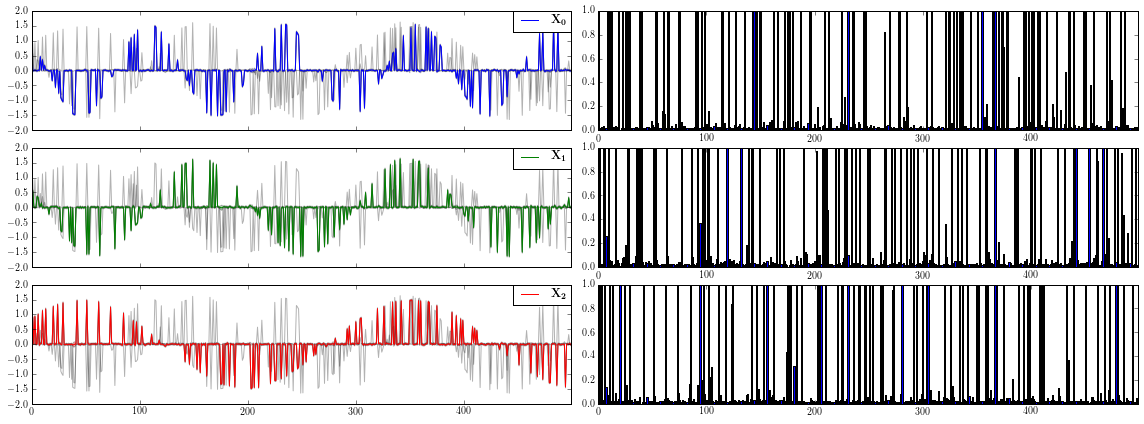

In [7]:
# Plot the posterior distribution of X
# The left figure shows the mean and variance (the thickness) of 
# the slab part (the gray color shows the other dimensions for comparison)
# The right figure shows the posterior probability of the binary variable for having the slab
a = m.X.plot()

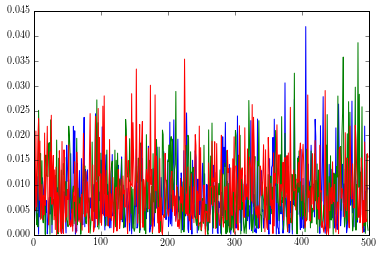

In [8]:
# In order to compare the recovered X, we flipped the sign of the 2nd, 3rd dimensions, and rescale the values.
# The figure shows the absolute difference between the recovered X and the original X
Xcom = m.X.mean.copy()*np.array([1.,-1.,-1.])
Xcom = Xcom/np.abs(Xcom).max(axis=0)
_ = plot(np.abs(Xcom-X))

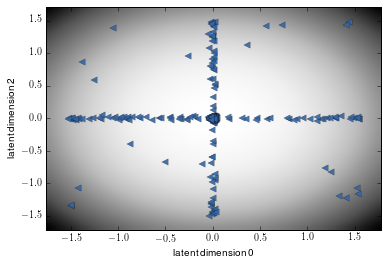

In [9]:
# Plot the distribution of the recovered X (only 1st and 3rd dimension)
# As shown in the figure, it follows a spike and slab distribution
_ = m.plot_latent()

## Apply Bayesian GP-LVM

As a comparison, we also apply the synthetic data to the original Bayesian GPLVM model.

In [10]:
m = GPy.models.BayesianGPLVM(y, Q, kernel=GPy.kern.Linear(Q,ARD=True),num_inducing=Q)
# Show the model parameters
print m


Name : bayesian gplvm
Objective : 51624.7110985
Number of Parameters : 3013
Number of Optimization Parameters : 3013
Updates : True
Parameters:
  bayesian_gplvm.          |     value  |  constraints  |  priors
  latent space.mean        |  (500, 3)  |               |        
  latent space.variance    |  (500, 3)  |      +ve      |        
  inducing inputs          |    (3, 3)  |               |        
  linear.variances         |      (3,)  |      +ve      |        
  Gaussian_noise.variance  |       1.0  |      +ve      |        


In [11]:
# Optimize the model parameters
m.optimize('bfgs',messages=1,max_iters=10000)

In [12]:
# Show the model parameters after optimization
print m


Name : bayesian gplvm
Objective : -3717.46060167
Number of Parameters : 3013
Number of Optimization Parameters : 3013
Updates : True
Parameters:
  bayesian_gplvm.          |            value  |  constraints  |  priors
  latent space.mean        |         (500, 3)  |               |        
  latent space.variance    |         (500, 3)  |      +ve      |        
  inducing inputs          |           (3, 3)  |               |        
  linear.variances         |             (3,)  |      +ve      |        
  Gaussian_noise.variance  |  0.0392832125766  |      +ve      |        


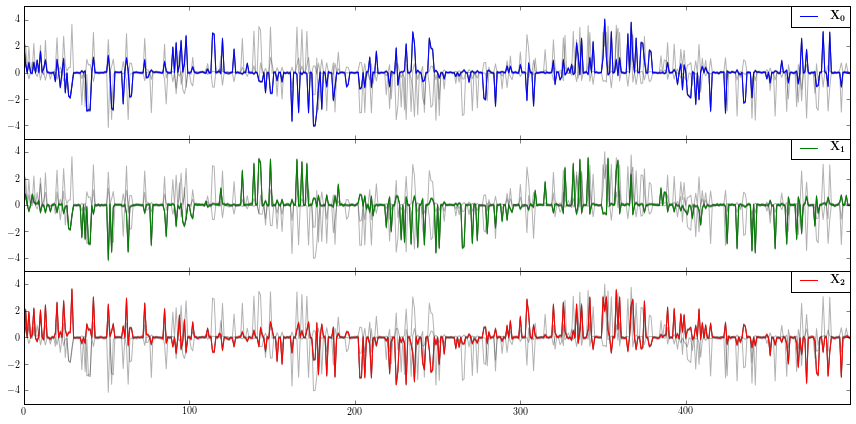

In [13]:
# Plot the posterior distribution of X
a = m.X.plot()

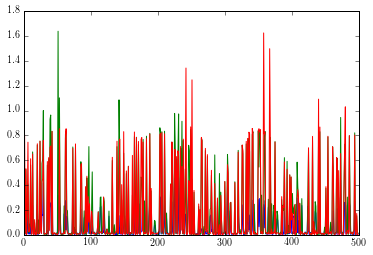

In [14]:
# In order to compare the recovered X, we swapped the 2nd and 3rd dimension, 
# flipped the sign of the 2nd dimension, and rescale the values.
# The figure shows the absolute difference between the recovered X and the original X
Xcom = np.dot(m.X.mean.copy(),np.array([[1.,0.,0.],[0.,0.,1.],[0.,-1.,0.]]))
Xcom = Xcom/np.abs(Xcom).max(axis=0)
_ = plot(np.abs(Xcom-X))

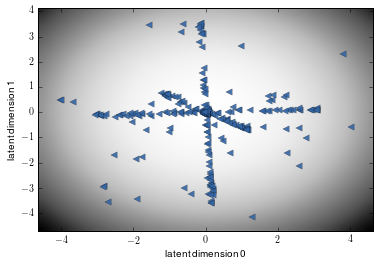

In [15]:
# Plot the distribution of the recovered X (only 1st and 2nd dimension)
# As shown in the figure, it follows a spike and slab distribution
_ = m.plot_latent()